#**Quora Toxic Question Classification**


###unzip data

In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"bruce374","key":"43313de75c23e8c5a1b9713cc04183c0"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c quora-insincere-questions-classification

 61% 33.0M/54.4M [00:01<00:01, 13.2MB/s]
100% 54.4M/54.4M [00:02<00:00, 27.6MB/s]
100% 5.95G/5.96G [01:42<00:00, 75.5MB/s]
100% 5.96G/5.96G [01:42<00:00, 62.1MB/s]
100% 4.08M/4.08M [00:00<00:00, 14.6MB/s]

 57% 9.00M/15.7M [00:01<00:00, 7.58MB/s]
100% 15.7M/15.7M [00:01<00:00, 14.7MB/s]


In [2]:
!ls

embeddings.zip	sample_submission.csv.zip  train.csv.zip
sample_data	test.csv.zip


In [3]:
!unzip embeddings.zip

Archive:  embeddings.zip
   creating: GoogleNews-vectors-negative300/
   creating: glove.840B.300d/
   creating: paragram_300_sl999/
   creating: wiki-news-300d-1M/
  inflating: glove.840B.300d/glove.840B.300d.txt  
  inflating: GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin  
  inflating: wiki-news-300d-1M/wiki-news-300d-1M.vec  
  inflating: paragram_300_sl999/README.txt  
  inflating: paragram_300_sl999/paragram_300_sl999.txt  


In [4]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [5]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


###import

In [1]:

import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, MaxPool2D, Concatenate, CuDNNLSTM,SpatialDropout1D,GlobalMaxPooling1D,concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D, BatchNormalization
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import *
from keras.layers.core import Lambda

from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import *
import tensorflow as tf

Using TensorFlow backend.


## Processing data


### load data

In [2]:
tqdm.pandas()
train_df = pd.read_csv("./train.csv")
#test_df = pd.read_csv("./test.csv")
print("Train shape : ",train_df.shape)
#print("Test shape : ",test_df.shape)

Train shape :  (1306122, 3)


In [0]:
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


### Data Cleaning

####build dictionary of words and their count

In [0]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab
def vocab_dic(train):
  sentences = train["question_text"].progress_apply(lambda x: x.split()).values
  vocab = build_vocab(sentences)
  return vocab
#print({k: vocab[k] for k in list(vocab)[:5]})

####Embedding function

In [0]:
def embedding_dic(path):
  EMBEDDING_FILE = path

  def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
  embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

  return embeddings_index

####Cleaning Methods

In [0]:
# Check Coverage
import operator 

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('\nFound embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x
  
# Implement removal methods
def Remov(train,f):
  train["question_text"] = train["question_text"].progress_apply(lambda x: f(x))
  sentences = train["question_text"].apply(lambda x: x.split())
  vocab = build_vocab(sentences)
  return vocab,train

#step 1 :remove symbol
def clean_text(x):

    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x
  
#step 2 : remove number
import re

def clean_numbers(x):

    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    
    
    return x
  
#step 3 : build a dict to do simple preprocessing remove prep and mispell and top underflow
def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


mispell_dict = {'bitcoins':'bitcoin',
                'centre':'center',
                'didnt':'did not',
                'doesnt':'does not',
                'isnt':'is not',
                'shouldnt':'should not',
                'favourite':'favorite',
                'travelling':'traveling',
                'counselling':'counseling',
                'theatre':'theater',
                'cancelled':'canceled',
                'labour':'labor',
                'organisation':'organization',
                'wwii':'world war 2',
                'citicise':'criticize',
                'instagram': 'socialmedium',
                'whatsapp': 'socialmedium',
                'Snapchat': 'socialmedium',
                'Btech': 'btech',
                
                

                }
mispellings, mispellings_re = _get_mispell(mispell_dict)
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)  #replace all the keys if in dict

####OOV

In [0]:
def OOV(embeddings_index,train_df):
  
  
  print("\nRaw embeddings:\n")
  vocab_raw = vocab_dic(train_df)
  oov_raw = check_coverage(vocab_raw,embeddings_index)
  print("\ntop20 oov\n")
  for i in oov_raw[:20]:print(i)
  
  print("\nClean text:\n")
  vocab_retext,train_retext = Remov(train_df,clean_text)
  oov_retext = check_coverage(vocab_retext,embeddings_index)
  for i in oov_retext[:20]:print(i)
  
  print("\nClean numbers:\n")
  vocab_renum,train_renum = Remov(train_retext,clean_numbers)
  oov_renum = check_coverage(vocab_renum,embeddings_index)
  for i in oov_renum[:20]:print(i)
  
  print("\nReplace misspelling:\n")
  vocab_respell,train_respell = Remov(train_renum,replace_typical_misspell)
  oov_respell = check_coverage(vocab_respell,embeddings_index)
  for i in oov_respell[:20]:print(i)
  
  print("\n Remove 'a','an','to','of','and','is','it','that','am','are','were' \n")
  sentences = train_respell["question_text"].progress_apply(lambda x: x.split())
  to_remove = ['a','an','to','of','and','is','it','that','am','are','were']
  sentences = [[word.lower() for word in sentence if not word in to_remove] for sentence in tqdm(sentences)]
  vocab = build_vocab(sentences)
  oov = check_coverage(vocab,embeddings_index)
  for i in oov[:20]:print(i)
  
  return train_respell
  
  
  

#### GoogleNews-vectors
though shows the coverage of removed "and, of...", returned trainset not remove in fact

In [12]:
from gensim.models import KeyedVectors
news_path = './GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'
embeddings_index_go = KeyedVectors.load_word2vec_format(news_path, binary=True)

#vocab_raw = vocab_dic(train_df) #computed before
train = OOV(embeddings_index_go,train_df)

/usr/local/lib/python3.6/dist-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
  2%|▏         | 24407/1306122 [00:00<00:05, 243923.10it/s]


Raw embeddings:



  1%|          | 7499/1306122 [00:00<00:17, 74988.46it/s]


Found embeddings for 24.31% of vocab
Found embeddings for  78.75% of all text

top20 oov

('to', 403183)
('a', 402682)
('of', 330825)
('and', 251973)
('India?', 16384)
('it?', 12900)
('do?', 8753)
('life?', 7753)
('you?', 6295)
('me?', 6202)
('them?', 6140)
('time?', 5716)
('world?', 5386)
('people?', 4971)
('why?', 4943)
('Quora?', 4655)
('10', 4591)
('like?', 4487)
('for?', 4450)
('work?', 4206)

Clean text:



  1%|          | 6737/1306122 [00:00<00:19, 67364.44it/s]


Found embeddings for 57.38% of vocab
Found embeddings for  89.99% of all text
('to', 406298)
('a', 403852)
('of', 332964)
('and', 254081)
('2017', 8781)
('2018', 7373)
('10', 6642)
('12', 3694)
('20', 2942)
('100', 2883)
('15', 2762)
('12th', 2551)
('11', 2356)
('30', 2163)
('18', 2066)
('50', 1993)
('16', 1589)
('14', 1533)
('17', 1505)
('13', 1390)

Clean numbers:



  1%|          | 15155/1306122 [00:00<00:08, 151546.17it/s]


Found embeddings for 60.41% of vocab
Found embeddings for  90.75% of all text
('to', 406298)
('a', 403852)
('of', 332964)
('and', 254081)
('favourite', 1247)
('bitcoin', 987)
('colour', 976)
('doesnt', 918)
('centre', 886)
('Quorans', 858)
('cryptocurrency', 822)
('Snapchat', 807)
('travelling', 705)
('counselling', 634)
('btech', 632)
('didnt', 600)
('Brexit', 493)
('cryptocurrencies', 481)
('blockchain', 474)
('behaviour', 468)

Replace misspelling:



  2%|▏         | 25406/1306122 [00:00<00:05, 254055.40it/s]


Found embeddings for 60.42% of vocab
Found embeddings for  90.80% of all text
('to', 406298)
('a', 403852)
('of', 332964)
('and', 254081)
('bitcoin', 1241)
('colour', 976)
('btech', 894)
('Quorans', 858)
('cryptocurrency', 822)
('socialmedium', 816)
('Brexit', 493)
('cryptocurrencies', 481)
('blockchain', 474)
('behaviour', 468)
('upvotes', 432)
('programme', 402)
('Redmi', 379)
('realise', 371)
('defence', 364)
('KVPY', 349)

 Remove 'a','an','to','of','and','is','it','that','am','are','were' 



100%|██████████| 199719/199719 [00:00<00:00, 359301.28it/s]



Found embeddings for 38.69% of vocab
Found embeddings for  97.31% of all text
('quora', 15842)
('a', 5886)
('and', 3716)
('instagram', 2497)
('bitcoin', 2236)
('upsc', 2174)
('to', 1584)
('btech', 1582)
('mbbs', 1572)
('whatsapp', 1507)
('ece', 1142)
('aiims', 1036)
('colour', 985)
('iim', 963)
('mtech', 961)
('sbi', 947)
('cgl', 928)
('cryptocurrency', 873)
('quorans', 860)
('socialmedium', 816)


####GloVe
remove and of&number will decrease the coverage

In [13]:
embeddings_index_gl = embedding_dic('./glove.840B.300d/glove.840B.300d.txt')
train = OOV(embeddings_index_gl,train_df)


  1%|▏         | 17334/1306122 [00:00<00:07, 167736.16it/s]


Raw embeddings:



  1%|          | 7020/1306122 [00:00<00:18, 70199.06it/s]


Found embeddings for 71.07% of vocab
Found embeddings for  99.33% of all text

top20 oov

('##th', 5909)
('##s', 1210)
('####s', 1117)
('##k', 1100)
('Quorans', 858)
('socialmedium', 816)
('Brexit', 493)
('cryptocurrencies', 481)
('###k', 444)
('##st', 401)
('Redmi', 379)
('##m', 207)
('##K', 182)
('##kg', 179)
('##mm', 176)
('###m', 167)
('OnePlus', 125)
('UCEED', 123)
('##cm', 117)
('##x', 114)

Clean text:



  0%|          | 5004/1306122 [00:00<00:26, 50035.28it/s]


Found embeddings for 72.15% of vocab
Found embeddings for  99.47% of all text
('Quorans', 858)
('socialmedium', 816)
('Brexit', 493)
('cryptocurrencies', 481)
('Redmi', 380)
('₹', 182)
('OnePlus', 125)
('UCEED', 124)
('GDPR', 107)
('Blockchain', 107)
('demonetisation', 106)
('Coinbase', 104)
('BNBR', 99)
('Adityanath', 99)
('Machedo', 99)
('Boruto', 93)
('DCEU', 89)
('ethereum', 88)
('IIEST', 85)
('SJWs', 81)

Clean numbers:



  1%|          | 14052/1306122 [00:00<00:09, 140516.45it/s]


Found embeddings for 72.15% of vocab
Found embeddings for  99.47% of all text
('Quorans', 858)
('socialmedium', 816)
('Brexit', 493)
('cryptocurrencies', 481)
('Redmi', 380)
('₹', 182)
('OnePlus', 125)
('UCEED', 124)
('GDPR', 107)
('Blockchain', 107)
('demonetisation', 106)
('Coinbase', 104)
('BNBR', 99)
('Adityanath', 99)
('Machedo', 99)
('Boruto', 93)
('DCEU', 89)
('ethereum', 88)
('IIEST', 85)
('SJWs', 81)

Replace misspelling:



  2%|▏         | 26911/1306122 [00:00<00:04, 269106.41it/s]


Found embeddings for 72.15% of vocab
Found embeddings for  99.47% of all text
('Quorans', 858)
('socialmedium', 816)
('Brexit', 493)
('cryptocurrencies', 481)
('Redmi', 380)
('₹', 182)
('OnePlus', 125)
('UCEED', 124)
('GDPR', 107)
('Blockchain', 107)
('demonetisation', 106)
('Coinbase', 104)
('BNBR', 99)
('Adityanath', 99)
('Machedo', 99)
('Boruto', 93)
('DCEU', 89)
('ethereum', 88)
('IIEST', 85)
('SJWs', 81)

 Remove 'a','an','to','of','and','is','it','that','am','are','were' 



100%|██████████| 196962/196962 [00:00<00:00, 728728.98it/s]



Found embeddings for 60.26% of vocab
Found embeddings for  99.12% of all text
('quorans', 860)
('socialmedium', 816)
('brexit', 524)
('cryptocurrencies', 499)
('redmi', 384)
('kvpy', 356)
('paytm', 355)
('iiser', 345)
('ethereum', 331)
('iisc', 278)
('jinping', 211)
('viteee', 185)
('₹', 182)
('iocl', 177)
('nmims', 163)
('upes', 157)
('rohingya', 157)
('fortnite', 156)
('iitians', 147)
('cpec', 146)


In [0]:
# The final process for further model
# only deal with the last word
print("\nRaw embeddings:\n")
vocab_raw = vocab_dic(train_df)
oov_raw = check_coverage(vocab_raw,embeddings_index_gl)
print("\ntop20 oov\n")
for i in oov_raw[:20]:print(i)

print("\nClean text:\n")
vocab_retext,train_retext = Remov(train_df,clean_text)
oov_retext = check_coverage(vocab_retext,embeddings_index_gl)
for i in oov_retext[:20]:print(i)

####wiki-news
 original embedding is good enough

In [7]:
embeddings_index_wi = embedding_dic('../content/wiki-news-300d-1M/wiki-news-300d-1M.vec')

train = OOV(embeddings_index_wi,train_df)

  2%|▏         | 22391/1306122 [00:00<00:05, 223907.01it/s]


Raw embeddings:



  1%|          | 7825/1306122 [00:00<00:16, 78248.21it/s]


Found embeddings for 30.05% of vocab
Found embeddings for  87.66% of all text

top20 oov

('India?', 16384)
("don't", 14991)
('it?', 12900)
("I'm", 12811)
("What's", 12425)
('do?', 8753)
('life?', 7753)
("can't", 7077)
('you?', 6295)
('me?', 6202)
('them?', 6140)
("doesn't", 5733)
('time?', 5716)
('world?', 5386)
('people?', 4971)
('why?', 4943)
("it's", 4817)
('Quora?', 4655)
('like?', 4487)
('for?', 4450)

Clean text:



  0%|          | 5886/1306122 [00:00<00:22, 58850.37it/s]


Found embeddings for 63.85% of vocab
Found embeddings for  99.26% of all text
('Quorans', 858)
('BITSAT', 561)
('COMEDK', 352)
('KVPY', 349)
('Quoran', 308)
('mtech', 281)
('WBJEE', 230)
('bcom', 199)
('articleship', 191)
('VITEEE', 182)
('UPES', 153)
('aadhar', 150)
('marksheet', 135)
('Fortnite', 130)
('UCEED', 123)
('AFCAT', 122)
('dropshipping', 111)
('Nodejs', 105)
('UPSEE', 105)
('BNBR', 99)

Clean numbers:



  1%|▏         | 16608/1306122 [00:00<00:07, 166078.57it/s]


Found embeddings for 64.26% of vocab
Found embeddings for  98.53% of all text
('##', 52745)
('####', 33885)
('###', 18036)
('##th', 5909)
('#####', 4592)
('##s', 1210)
('####s', 1117)
('##k', 1100)
('Quorans', 858)
('BITSAT', 561)
('###k', 444)
('##st', 401)
('COMEDK', 352)
('KVPY', 349)
('Quoran', 308)
('mtech', 281)
('WBJEE', 230)
('##m', 207)
('bcom', 199)
('articleship', 191)

Replace misspelling:



  2%|▏         | 23905/1306122 [00:00<00:05, 239049.09it/s]


Found embeddings for 64.25% of vocab
Found embeddings for  98.53% of all text
('##', 52745)
('####', 33885)
('###', 18036)
('##th', 5909)
('#####', 4592)
('##s', 1210)
('####s', 1117)
('##k', 1100)
('Quorans', 858)
('socialmedium', 816)
('BITSAT', 561)
('###k', 444)
('##st', 401)
('COMEDK', 352)
('KVPY', 349)
('Quoran', 308)
('mtech', 281)
('WBJEE', 230)
('##m', 207)
('bcom', 199)

 Remove 'a','an','to','of','and','is','it','that','am','are','were' 



100%|██████████| 199719/199719 [00:00<00:00, 776152.70it/s]



Found embeddings for 45.45% of vocab
Found embeddings for  97.48% of all text
('##', 52745)
('####', 33885)
('###', 18036)
('##th', 5914)
('#####', 4592)
('upsc', 2174)
('##k', 1282)
('##s', 1220)
('####s', 1119)
('aiims', 1036)
('mtech', 961)
('cgl', 928)
('quorans', 860)
('socialmedium', 816)
('jio', 770)
('manipal', 741)
('icse', 657)
('iiit', 564)
('bitsat', 561)
('cgpa', 557)


####paragram_300
need do lower case

In [8]:

embeddings_index_pa =embedding_dic('./paragram_300_sl999/paragram_300_sl999.txt')

train = OOV(embeddings_index_pa,train_df)

  1%|▏         | 19101/1306122 [00:00<00:06, 191009.73it/s]


Raw embeddings:



  1%|          | 7610/1306122 [00:00<00:17, 76097.53it/s]


Found embeddings for 38.17% of vocab
Found embeddings for  81.02% of all text

top20 oov

('What', 430832)
('I', 325901)
('How', 263104)
('Why', 145159)
('Is', 108970)
('Can', 53043)
('Which', 47349)
('Do', 40147)
('If', 34769)
('India', 32725)
('Are', 29254)
('Does', 23211)
('Who', 22521)
('Where', 19377)
('Should', 16615)
('Quora', 15821)
('US', 15510)
('Will', 14695)
('When', 14639)
('Trump', 13970)

Clean text:



  1%|          | 6656/1306122 [00:00<00:19, 66555.14it/s]


Found embeddings for 38.74% of vocab
Found embeddings for  81.00% of all text
('What', 430841)
('I', 325950)
('How', 263113)
('Why', 145160)
('Is', 108974)
('Can', 53044)
('Which', 47352)
('Do', 40148)
('If', 34772)
('India', 32727)
('Are', 29254)
('Does', 23211)
('Who', 22521)
('Where', 19377)
('Should', 16615)
('Quora', 15821)
('US', 15523)
('Will', 14697)
('When', 14639)
('Trump', 13970)

Clean numbers:



  1%|          | 15515/1306122 [00:00<00:08, 155144.23it/s]


Found embeddings for 38.74% of vocab
Found embeddings for  81.00% of all text
('What', 430841)
('I', 325950)
('How', 263113)
('Why', 145160)
('Is', 108974)
('Can', 53044)
('Which', 47352)
('Do', 40148)
('If', 34772)
('India', 32727)
('Are', 29254)
('Does', 23211)
('Who', 22521)
('Where', 19377)
('Should', 16615)
('Quora', 15821)
('US', 15523)
('Will', 14697)
('When', 14639)
('Trump', 13970)

Replace misspelling:



  2%|▏         | 25452/1306122 [00:00<00:05, 251562.17it/s]


Found embeddings for 38.74% of vocab
Found embeddings for  81.00% of all text
('What', 430841)
('I', 325950)
('How', 263113)
('Why', 145160)
('Is', 108974)
('Can', 53044)
('Which', 47352)
('Do', 40148)
('If', 34772)
('India', 32727)
('Are', 29254)
('Does', 23211)
('Who', 22521)
('Where', 19377)
('Should', 16615)
('Quora', 15821)
('US', 15523)
('Will', 14697)
('When', 14639)
('Trump', 13970)

 Remove 'a','an','to','of','and','is','it','that','am','are','were' 



100%|██████████| 196962/196962 [00:00<00:00, 696851.80it/s]



Found embeddings for 71.00% of vocab
Found embeddings for  99.46% of all text
('quorans', 860)
('socialmedium', 816)
('brexit', 524)
('cryptocurrencies', 499)
('redmi', 384)
('₹', 182)
('coinbase', 145)
('oneplus', 138)
('uceed', 124)
('demonetisation', 115)
('bhakts', 115)
('machedo', 108)
('gdpr', 107)
('adityanath', 106)
('boruto', 102)
('upwork', 101)
('bnbr', 100)
('alshamsi', 92)
('dceu', 90)
('litecoin', 87)


### Data Splitting

#### Method 1
original splitting: 80% training 10% val 10%test

In [0]:
train_90, test_10 = train_test_split(train_retext, test_size=0.1)
train_80, val_10 = train_test_split(train_90, test_size=0.1111)


In [0]:
print(train_80.shape)
print(val_10.shape)
print(test_10.shape)

(1044909, 3)
(130600, 3)
(130613, 3)


In [0]:
!pip install hickle

In [0]:
# save the cleaned and splitted data

# import hickle as hkl
# hkl.dump(train_80,'train_80_0.hkl')
# hkl.dump(val_10,'val_10.hkl')
# hkl.dump(test_10,'test_10.hkl')


In [0]:
#load the data

# import hickle as hkl
# train_80 = hkl.load('train_80_0.hkl')
# val_10 = hkl.load('val_10.hkl')
# test_10 = hkl.load('test_10.hkl')


####Method 2
Sampling data by 7:3: "Untoxic" data do sampling and "Toxic" data do boostrap


In [0]:
train_80.reset_index(drop=True,inplace=True)
strati = train_80.groupby("target")# save index
recN = train_80.shape[0]
tox = strati.groups[1] 
untox = strati.groups[0]
import random
train_new = pd.concat([train_80.iloc[random.sample(list(untox),int(recN*0.85))],train_80.iloc[random.choices(list(tox),k=int(recN*0.15))]])

In [0]:
train_90, test_10 = train_test_split(train_new, test_size=0.1)
train_80, val_10 = train_test_split(train_90, test_size=0.1111)


In [0]:
print(train_80.shape)
print(val_10.shape)
print(test_10.shape)

(1044909, 3)
(130600, 3)
(130613, 3)


In [0]:
# Save the sampled data

# import hickle as hkl
# hkl.dump(train_new,'train_80_2.hkl')


In [0]:
#load the sampled data

# train_80 = hkl.load('train_80_2.hkl')
# val_10 = hkl.load('val_10.hkl')
# test_10 = hkl.load('test_10.hkl')

###Embeddings

In [0]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

#train_80 = train_new
## fill up the missing values
train_X = train_80["question_text"].fillna("_na_").values
val_X = val_10["question_text"].fillna("_na_").values
test_X = test_10["question_text"].fillna("_na_").values


## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))#size
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

## Get the target values
train_y = train_80['target'].values
val_y = val_10['target'].values
test_y = test_10['target'].values


### Embedding
embeddings_index = embeddings_index_gl

print(len(embeddings_index),embeddings_index['UNK'].shape)
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

# compute embedding matrix & solving the uncovered words
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

2196016 (300,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.


In [0]:
#save the embedding matrix
# hkl.dump(embedding_matrix,'embedding_matrix.hkl')

In [0]:
#laod the embedding matrix
# embedding_matrix = hkl.load('embedding_matrix.hkl')

##Build model

In [0]:
#LSTM+GRU ensemble
inp = Input(shape=(maxlen,))
x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
#x = SpatialDropout1D(0.3)(x)
x1 = Bidirectional(CuDNNLSTM(256, return_sequences=True))(x)
x2 = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)

max_pool1 = GlobalMaxPooling1D()(x1)
max_pool2 = GlobalMaxPooling1D()(x2)
conc = Concatenate()([max_pool1, max_pool2])
predictions = Dense(1, activation='sigmoid')(conc)
model = Model(inputs=inp, outputs=predictions)
#adam = optimizers.Adam(lr=learning_rate)
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 100, 300)     15000000    input_9[0][0]                    
__________________________________________________________________________________________________
bidirectional_18 (Bidirectional (None, 100, 512)     1142784     embedding_9[0][0]                
__________________________________________________________________________________________________
bidirectional_19 (Bidirectional (None, 100, 256)     330240      embedding_9[0][0]                
__________________________________________________________________________________________________
global_max

In [0]:
# Baseline two layers GRU

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
#x = BatchNormalization()(x)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
#x = BatchNormalization()(x)
x = GlobalMaxPool1D()(x) 
x = Dense(64, activation="relu")(x)
#x = Dropout(0.1)(x)
#x = BatchNormalization()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
#x = BatchNormalization()(x)
x = Dense(1, activation="sigmoid")(x)


model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam')
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 256)          330240    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 128)          123648    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                1040      
__________

In [0]:
# BiLSTM+CNN

filters=[100, 80, 30, 12]    
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
#x = SpatialDropout1D(rate=0.2)(x)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True, 
                           kernel_initializer=glorot_uniform(), 
                           recurrent_initializer=Orthogonal(gain=1.00)))(x)
x = BatchNormalization()(x)
x1 = Conv1D(filters=filters[0], activation='relu', kernel_size=1, 
            padding='same', kernel_initializer=glorot_uniform())(x)
x2 = Conv1D(filters=filters[1], activation='relu', kernel_size=2, 
            padding='same', kernel_initializer=glorot_uniform())(x)
x3 = Conv1D(filters=filters[2], activation='relu', kernel_size=3, 
            padding='same', kernel_initializer=glorot_uniform())(x)
x4 = Conv1D(filters=filters[3], activation='relu', kernel_size=5, 
            padding='same', kernel_initializer=glorot_uniform())(x)


x1 = GlobalMaxPool1D()(x1)
x2 = GlobalMaxPool1D()(x2)
x3 = GlobalMaxPool1D()(x3)
x4 = GlobalMaxPool1D()(x4)

c = concatenate([x1, x2, x3, x4])
x = Dense(200, activation='relu', kernel_initializer=glorot_uniform())(c)
#x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(16, activation="relu")(x)
#x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Dense(1, activation="sigmoid", kernel_initializer=glorot_uniform())(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 100, 300)     15000000    input_8[0][0]                    
__________________________________________________________________________________________________
bidirectional_17 (Bidirectional (None, 100, 256)     440320      embedding_8[0][0]                
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 100, 256)     1024        bidirectional_17[0][0]           
__________________________________________________________________________________________________
conv1d_1 (

In [0]:
#3-layer-BiGRU + Attention


class AttentionWeightedAverage(Layer):
    """
    Computes a weighted average of the different channels across timesteps.
    Uses 1 parameter pr. channel to compute the attention value for a single timestep.
    """

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.RandomUniform()
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_W'.format(self.name),
                                 initializer=self.init)
        self.trainable_weights = [self.W]
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, x, mask=None):
        # computes a probability distribution over the timesteps
        # uses 'max trick' for numerical stability
        # reshape is done to avoid issue with Tensorflow
        # and 1-dimensional weights
        logits = K.dot(x, self.W)
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))

        # masked timesteps have zero weight
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            ai = ai * mask
        att_weights = ai / (K.sum(ai, axis=1, keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, att_weights]
        return result

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None





K.clear_session()
inp = Input(shape=(maxlen,))
embedding_layer = Embedding(max_features,
                            embed_size,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False)(inp)
embedding_layer = SpatialDropout1D(0.2)(embedding_layer)

rnn_1 = Bidirectional(CuDNNGRU(256, return_sequences=True, 
                               kernel_initializer=glorot_uniform(), 
                               recurrent_initializer=Orthogonal(gain=1.0)))(embedding_layer)
rnn_1 = Bidirectional(CuDNNGRU(190, return_sequences=True, 
                               kernel_initializer=glorot_uniform(), 
                               recurrent_initializer=Orthogonal(gain=1.0)))(rnn_1)
rnn_1 = Bidirectional(CuDNNGRU(128, return_sequences=True, 
                               kernel_initializer=glorot_uniform(), 
                               recurrent_initializer=Orthogonal(gain=1.0)))(rnn_1)

last = Lambda(lambda t: t[:, -1], name='last')(rnn_1)
maxpool = GlobalMaxPooling1D()(rnn_1)
attn = AttentionWeightedAverage()(rnn_1)
average = GlobalAveragePooling1D()(rnn_1)

c = concatenate([last, maxpool, attn], axis=1)
c = Reshape((3, -1))(c)
c = Lambda(lambda x:K.sum(x, axis=1))(c)
x = BatchNormalization()(c)
x = Dense(100, activation='relu', kernel_initializer=glorot_uniform())(x)
x = Dropout(0.1)(x)
x = Dense(64, activation="relu")(x)
#x = Dropout(0.1)(x)
x = Dense(16, activation="relu")(x)
#x = Dropout(0.1)(x)
x = BatchNormalization()(x)
output_layer = Dense(1, activation="sigmoid", kernel_initializer=glorot_uniform())(x)
model = Model(inputs=inp, outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
print(model.summary())

#0.687

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     15000000    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 512)     857088      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
bidirectio

## Train model

In [0]:
model.fit(train_X, train_y, batch_size=256, epochs=2, validation_data=(val_X, val_y))

In [0]:
pred_noemb_val_y = model.predict([val_X], batch_size=1024, verbose=1)
pred_noemb_val_y

In [0]:
# save predict y score
# pred_y = pd.DataFrame(pred_noemb_val_y)
# pred_y.to_csv("pred_y.csv",index=False,sep=',')

In [0]:
!pip install matplotlib

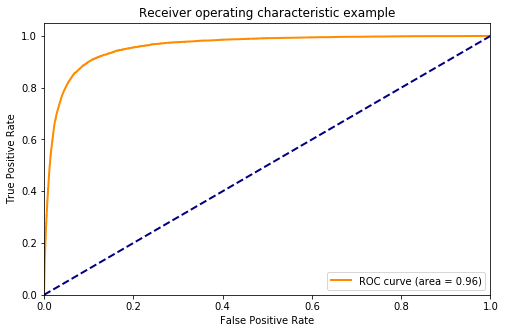

In [0]:
# draw roc curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds_skl = metrics.roc_curve(val_y, pred_noemb_val_y)
roc_auc = metrics.auc(fpr,tpr)
lw = 2
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [0]:
# compute AUC
#metrics.roc_auc_score(val_y, pred_noemb_val_y)

0.9586422853501325

In [0]:
# compute F1 score and Accuracy

a =0
f1 = 0
for thresh in np.arange(0.1, 0.99, 0.01):
    thresh = np.round(thresh, 2)
    if metrics.accuracy_score(val_y, (pred_noemb_val_y>thresh).astype(int))>a:
      print("Acuuracy score at threshold {0} is {1}".format(thresh, metrics.accuracy_score(val_y, (pred_noemb_val_y>thresh).astype(int))))
      a = metrics.accuracy_score(val_y, (pred_noemb_val_y>thresh).astype(int))
    if metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))>f1:
      print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))))
      f1 = metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))
    